In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import math
import seaborn as sns
from IPython.core.display import display, HTML
#display(HTML(my_html))     # make sure Jupyter knows to display it as HTML

In [54]:
dirs = {'fassbinder': 'https://www.imdb.com/name/nm0001202/', \
        'godard':'https://www.imdb.com/name/nm0000419/', \
        'hitchcock': 'https://www.imdb.com/name/nm0000033', \
        'speilberg': 'https://www.imdb.com/name/nm0000229', \
        'kurosawa': 'https://www.imdb.com/name/nm0000041/', \
        'bergman': 'https://www.imdb.com/name/nm0000005/', \
        'allen': 'https://www.imdb.com/name/nm0000095',\
        'herzog': 'https://www.imdb.com/name/nm0001348/'}

In [59]:
dirs_page = dirs['herzog']
url = dirs_page
response = requests.get(url)
print( response.status_code )
page = response.text
soup = BeautifulSoup(page, "lxml")
films = soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))

200


* Clean the datapoints below
* Ensure they are available or handled for each film's page
* Convert into numeric datatypes
* Populate a list of dictionaries with these 
* Within the loop that goes through every flick, populate the list of dictionaries with these
* Do one-hot-encoding on categorical variables
* Train and test the linear regression model

In [55]:
def is_tv_series( the_film_soup ):
    try:
        parenthesis = the_film_soup.find('a').next
        try:
            if 'TV ' in parenthesis.next:
                return True
            else:
                return False
        except:
            return False
    except:
        return False

In [57]:
def is_documentary( the_film_soup ):
    try:
        parenthesis = the_film_soup.find('a').next
        #print(parenthesis)
        try:
            if 'documentary' in parenthesis.next.lower():
                #print('DOCUMENTARY')
                return True
            else:
                return False
        except:
            return False
    except:
        return False

In [127]:
def parse_crew_data(the_crew_soup):
    crew_data = {}
    try: 
        print( the_crew_soup.find('h4', id='cinematographer').next_sibling )
        crew_data['cinematographer'] = the_crew_soup.find('h4', id='cinematographer').find_next_sibling('table', class_='simpleTable').find('a').text.strip()
    except: 
        crew_data['cinematographer'] = ''
    return (crew_data)

In [124]:
# TEST AREA
test_url = dirs['fassbinder']
test_response = requests.get(test_url)
test_page = test_response.text
test_soup = BeautifulSoup(test_page, "lxml")
test_row = test_soup.find(id='director-tt0080196')
#print(test_row)
'https://www.imdb.com/title/tt0084654/'
print( test_url)
#crew_url = test_url + '/fullcredits'
crew_url = 'https://www.imdb.com/title/tt0084654/fullcredits'
crew_response = requests.get(crew_url)
crew_page = crew_response.text
crew_soup = BeautifulSoup(crew_page, "lxml")

the_crew_data = parse_crew_data( crew_soup )
print(the_crew_data)
#print(is_tv_series(test_row))


https://www.imdb.com/name/nm0001202/
REACHED FUNCTION


REACHED INSIDE BLOCK
{'cinematographer': 'Xaver Schwarzenberger'}


In [129]:
def get_film_data_only_title( film_soup ):
    film_title_string = film_soup.find(class_ = 'title_wrapper').find('h1').text
    print(film_title_string)
    
# searching from the page_content might be more efficient. To be tested later
def parse_film_data( film_soup ):
    film_data = {}
    
    try:        
        film_title_string = film_soup.find(class_ = 'title_wrapper').find('h1').text
    except:
        film_title_string = ''
    title_line = film_title_string.split('\xa0(')
    film_data['title'] = title_line[0].replace('\xa0','').rstrip() # title part of title line
    
    film_data['year'] = title_line[1].replace(') ', '') if len(title_line) > 1 else '' # year part of title line
    
    try:
        film_rating_tag = film_soup.find('span', itemprop='ratingValue')
        try:
            film_rating_string = film_rating_tag.text   #find_next_sibling().text
        except:
            film_rating_string = None      
    except:
        film_rating_string = None 
    film_data['rating'] = film_rating_string
   
    try:
        film_rating_count_tag = film_soup.find('span', itemprop='ratingCount')
        try:
            film_rating_count = float( film_rating_count_tag.text.replace(',', '')) #find_next_sibling().text
        except:
            film_rating_count = None 
    except:
            film_rating_count = None 
    film_data['rating_count'] = film_rating_count
    
    try:
        film_duration_string = film_soup.find('time').text
        #print(film_duration_string.replace('min',''))
        dur_list = film_duration_string.replace('min','').rstrip().split('h ')
        film_data['duration'] = (int(dur_list[-1]) + 60*int(dur_list[0])) if (len(dur_list)>1) else int(dur_list[-1])
    except:
        film_data['duration'] = None
      
    try:
        film_date_string = film_soup.find('a', title='see more release dates')
    except:
        film_date_string = ''  
    
    try:
        film_release_date_tag = film_soup.find('h4', text=re.compile('Release Date:'))
        try:
            film_release_date = film_release_date_tag.next_sibling.replace('\n', '')
        except:
            film_release_date = '' 
    except:
            film_release_date = '' 
    film_data['release_date'] = film_release_date
    
    
    try:
        film_metacritic_score_tag = film_soup.find('div', class_=re.compile('metacriticScore'))
        try:
            film_metacritic_score = film_metacritic_score_tag.find('span').text
        except:
            film_metacritic_score = None #math.nan  
    except:
        film_metacritic_score = None #math.nan  
    film_data['metacritic_score'] = film_metacritic_score
    try:
        film_details = film_soup.find('div', class_='article', id='titleDetails')
        try:        
            film_gross_string = film_details.find('h4', text=re.compile('Cumulative Worldwide Gross:')).next_sibling
            film_gross = int( re.sub("[^0-9]", "", film_gross_string ))
        except:
             film_gross = None 
    except:
        film_gross = None 
    film_data['worldwide_gross']  = film_gross
    
    try:
        film_runtime_tag = film_soup.find('h4', text=re.compile('Runtime:'))
        try:
             film_runtime = int(film_runtime_tag.find_next_sibling().text.strip(' min'))
        except:
            film_runtime = None 
    except:
            film_runtime = None
    film_data['runtime'] = film_runtime
    try:
        film_budget_tag = film_soup.find('h4', text=re.compile('Budget'))
        try:
            film_budget = int( re.sub("[^0-9]", "", film_budget_tag.next_sibling ))
        except:
            film_budget = None #math.nan  
    except:
            film_budget = None #math.nan  
    film_data['budget'] = film_budget
      
    return film_data

In [130]:
list_of_films = []

for film in films:
    if ( not is_tv_series(film)): 
        film_url_suffix = film.find('a').get('href')
        film_url = 'https://imdb.com' + film_url_suffix
        print('\n', film_url)
        film_response = requests.get(film_url)
        if(film_response.status_code < 400):
            film_page = film_response.text
            film_soup = BeautifulSoup(film_page, "lxml")
            film_record = parse_film_data( film_soup )
            film_record['tv_series'] = False
    else:  # To be customized 
        film_url_suffix = film.find('a').get('href')
        film_url = 'https://imdb.com' + film_url_suffix
        print('\n', film_url)
        film_response = requests.get(film_url)
        if(film_response.status_code < 400):
            film_page = film_response.text
            film_soup = BeautifulSoup(film_page, "lxml")
            film_record = parse_film_data( film_soup )
            film_record['tv_series'] = True
            
    film_record['documentary'] = is_documentary(film)
    #print(film_record)
    
    crew_url = film_url + 'fullcredits'
   # print(crew_url)
    crew_response = requests.get(crew_url)
    crew_page = crew_response.text
    crew_soup = BeautifulSoup(crew_page, "lxml")
    film_record.update( parse_crew_data(crew_soup) )
    print(film_record)
    
    list_of_films.append(film_record)
        
film_catalog = pd.DataFrame(list_of_films )


 https://imdb.com/title/tt2357792/
{'title': 'Fordlandia', 'year': '', 'rating': None, 'rating_count': None, 'duration': None, 'release_date': '', 'metacritic_score': None, 'worldwide_gross': None, 'runtime': None, 'budget': None, 'tv_series': True, 'documentary': False, 'cinematographer': ''}

 https://imdb.com/title/tt9203832/
DOCUMENTARY


{'title': 'Fireball: Visitors from Darker Worlds', 'year': '2020', 'rating': '7.0', 'rating_count': 1411.0, 'duration': 97, 'release_date': ' 13 November 2020 (Australia)    ', 'metacritic_score': '72', 'worldwide_gross': None, 'runtime': 97, 'budget': None, 'tv_series': False, 'documentary': True, 'cinematographer': 'Peter Zeitlinger'}

 https://imdb.com/title/tt10208194/


{'title': 'Family Romance, LLC', 'year': '2019', 'rating': '6.7', 'rating_count': 1907.0, 'duration': 89, 'release_date': ' 3 July 2020 (USA)    ', 'metacritic_score': '68', 'worldwide_gross': 3126, 'runtime': 89, 'budget': None, 'tv_series': False, 'documentary': False, 'cin

DOCUMENTARY


{'title': 'The White Diamond', 'year': '2004', 'rating': '7.5', 'rating_count': 4375.0, 'duration': 88, 'release_date': ' 10 March 2005 (Germany)    ', 'metacritic_score': '83', 'worldwide_gross': None, 'runtime': 88, 'budget': 1000000, 'tv_series': False, 'documentary': True, 'cinematographer': 'Henning Brümmer'}

 https://imdb.com/title/tt0331080/
DOCUMENTARY


{'title': 'Wheel of Time', 'year': '2003', 'rating': '7.1', 'rating_count': 2289.0, 'duration': 80, 'release_date': ' 30 October 2003 (Germany)    ', 'metacritic_score': '65', 'worldwide_gross': None, 'runtime': 81, 'budget': None, 'tv_series': False, 'documentary': True, 'cinematographer': 'Peter Zeitlinger'}

 https://imdb.com/title/tt0304808/


{'title': 'Ten Minutes Older: The Trumpet', 'year': '2002', 'rating': '7.2', 'rating_count': 3239.0, 'duration': 92, 'release_date': ' 19 December 2002 (Germany)    ', 'metacritic_score': None, 'worldwide_gross': 62221, 'runtime': 92, 'budget': None, 'tv_series': False,

DOCUMENTARY


{'title': 'Gasherbrum - Der leuchtende Berg', 'year': '1985', 'rating': '7.6', 'rating_count': 793.0, 'duration': 45, 'release_date': ' 3 April 1985 (USA)    ', 'metacritic_score': None, 'worldwide_gross': None, 'runtime': 45, 'budget': None, 'tv_series': True, 'documentary': True, 'cinematographer': 'Rainer Klausmann'}

 https://imdb.com/title/tt0086936/
DOCUMENTARY


{'title': 'Ballade vom kleinen Soldaten', 'year': '1984', 'rating': '7.3', 'rating_count': 790.0, 'duration': 46, 'release_date': ' 3 April 1985 (USA)    ', 'metacritic_score': None, 'worldwide_gross': None, 'runtime': None, 'budget': None, 'tv_series': True, 'documentary': True, 'cinematographer': 'Michael Edols'}

 https://imdb.com/title/tt0088412/


{'title': 'Where the Green Ants Dream', 'year': '1984', 'rating': '7.1', 'rating_count': 2089.0, 'duration': 100, 'release_date': ' 8 February 1985 (USA)    ', 'metacritic_score': None, 'worldwide_gross': None, 'runtime': 100, 'budget': None, 'tv_series': Fal



{'title': 'Lebenszeichen', 'year': '1968', 'rating': '7.2', 'rating_count': 1914.0, 'duration': 91, 'release_date': ' 9 December 1981 (USA)    ', 'metacritic_score': None, 'worldwide_gross': None, 'runtime': 95, 'budget': 25000, 'tv_series': False, 'documentary': False, 'cinematographer': 'Thomas Mauch'}

 https://imdb.com/title/tt0061905/


{'title': 'Letzte Worte', 'year': '1968', 'rating': '6.1', 'rating_count': 801.0, 'duration': 13, 'release_date': ' 26 November 1976 (USA)    ', 'metacritic_score': None, 'worldwide_gross': None, 'runtime': 13, 'budget': None, 'tv_series': False, 'documentary': False, 'cinematographer': 'Thomas Mauch'}

 https://imdb.com/title/tt0061394/


{'title': 'Die beispiellose Verteidigung der Festung Deutschkreutz', 'year': '1967', 'rating': '5.9', 'rating_count': 703.0, 'duration': 15, 'release_date': ' 1967 (West Germany)    ', 'metacritic_score': None, 'worldwide_gross': None, 'runtime': 15, 'budget': None, 'tv_series': False, 'documentary': False, 'ci

In [131]:
film_catalog['year'] = pd.to_numeric(film_catalog['year'])
film_catalog['rating'] = pd.to_numeric(film_catalog['rating'])
film_catalog['worldwide_gross'] = pd.to_numeric(film_catalog['worldwide_gross'])
film_catalog['budget'] = pd.to_numeric(film_catalog['budget'])
film_catalog['metacritic_score'] = pd.to_numeric(film_catalog['metacritic_score'])

In [68]:
film_catalog.shape

(73, 12)

In [132]:
film_catalog.head(50)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross,runtime,budget,tv_series,documentary,cinematographer
0,Fordlandia,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,True,False,
1,Fireball: Visitors from Darker Worlds,2020.0,7.0,1411.0,97.0,13 November 2020 (Australia),72.0,NaN,97.0,NaN,False,True,Peter Zeitlinger
2,"Family Romance, LLC",2019.0,6.7,1907.0,89.0,3 July 2020 (USA),68.0,3126.0,89.0,NaN,False,False,Werner Herzog
3,Nomad: In the Footsteps of Bruce Chatwin,2019.0,6.9,544.0,85.0,26 August 2020 (USA),85.0,78100.0,85.0,NaN,False,True,Louis Caulfield
4,Meeting Gorbachev,2018.0,7.2,1685.0,90.0,3 May 2019 (USA),73.0,319230.0,90.0,NaN,False,True,Yuri Burak
5,Into the Inferno,2016.0,7.2,7377.0,104.0,28 October 2016 (USA),76.0,3679.0,104.0,NaN,False,True,Peter Zeitlinger
6,Salt and Fire,2016.0,4.2,2455.0,98.0,7 April 2017 (USA),44.0,23888.0,98.0,NaN,False,False,Peter Zeitlinger
7,Lo and Behold: Reveries of the Connected World,2016.0,7.0,11920.0,98.0,19 August 2016 (USA),76.0,765796.0,98.0,NaN,False,True,Peter Zeitlinger
8,Queen of the Desert,2015.0,5.7,10240.0,128.0,14 April 2017 (USA),39.0,1592853.0,128.0,15000000.0,False,False,Peter Zeitlinger
9,On Death Row,NaN,8.0,1088.0,49.0,9 March 2012 (USA),NaN,NaN,49.0,NaN,True,True,Peter Zeitlinger


In [79]:
film_catalog.tail(35)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross,runtime,budget,tv_series,documentary,cinematographer
38,Jag Mandir: Das exzentrische Privattheater des...,1991,6.4,193.0,82.0,10 November 1991 (Germany),None,NaN,82.0,NaN,True,True,temporary
39,Cerro Torre: Schrei aus Stein,1991,6.2,1252.0,105.0,3 October 1991 (Germany),None,NaN,105.0,6340000.0,False,False,temporary
40,Echoes From a Somber Empire,1990,7.2,566.0,91.0,28 November 1990 (France),None,NaN,NaN,NaN,False,True,temporary
41,Giovanna d'Arco,1989,6.0,63.0,127.0,,None,NaN,127.0,NaN,True,False,temporary
42,Wodaabe - Die Hirten der Sonne. Nomaden am Süd...,1989,7.3,664.0,52.0,12 June 1989 (West Germany),None,NaN,NaN,NaN,True,True,temporary
43,Les Français vus par,,6.4,883.0,13.0,1988 (France),None,NaN,13.0,NaN,True,False,temporary
44,Cobra Verde,1987,7.0,7170.0,111.0,3 December 1987 (West Germany),55,12702.0,111.0,800000.0,False,False,temporary
45,Werner Herzog: Filmemacher,1986,6.7,315.0,28.0,1986 (West Germany),None,NaN,28.0,NaN,False,True,temporary
46,Gasherbrum - Der leuchtende Berg,1985,7.6,793.0,45.0,3 April 1985 (USA),None,NaN,45.0,NaN,True,True,temporary
47,Ballade vom kleinen Soldaten,1984,7.3,790.0,46.0,3 April 1985 (USA),None,NaN,NaN,NaN,True,True,temporary


In [ ]:
film_catalog.dtypes

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


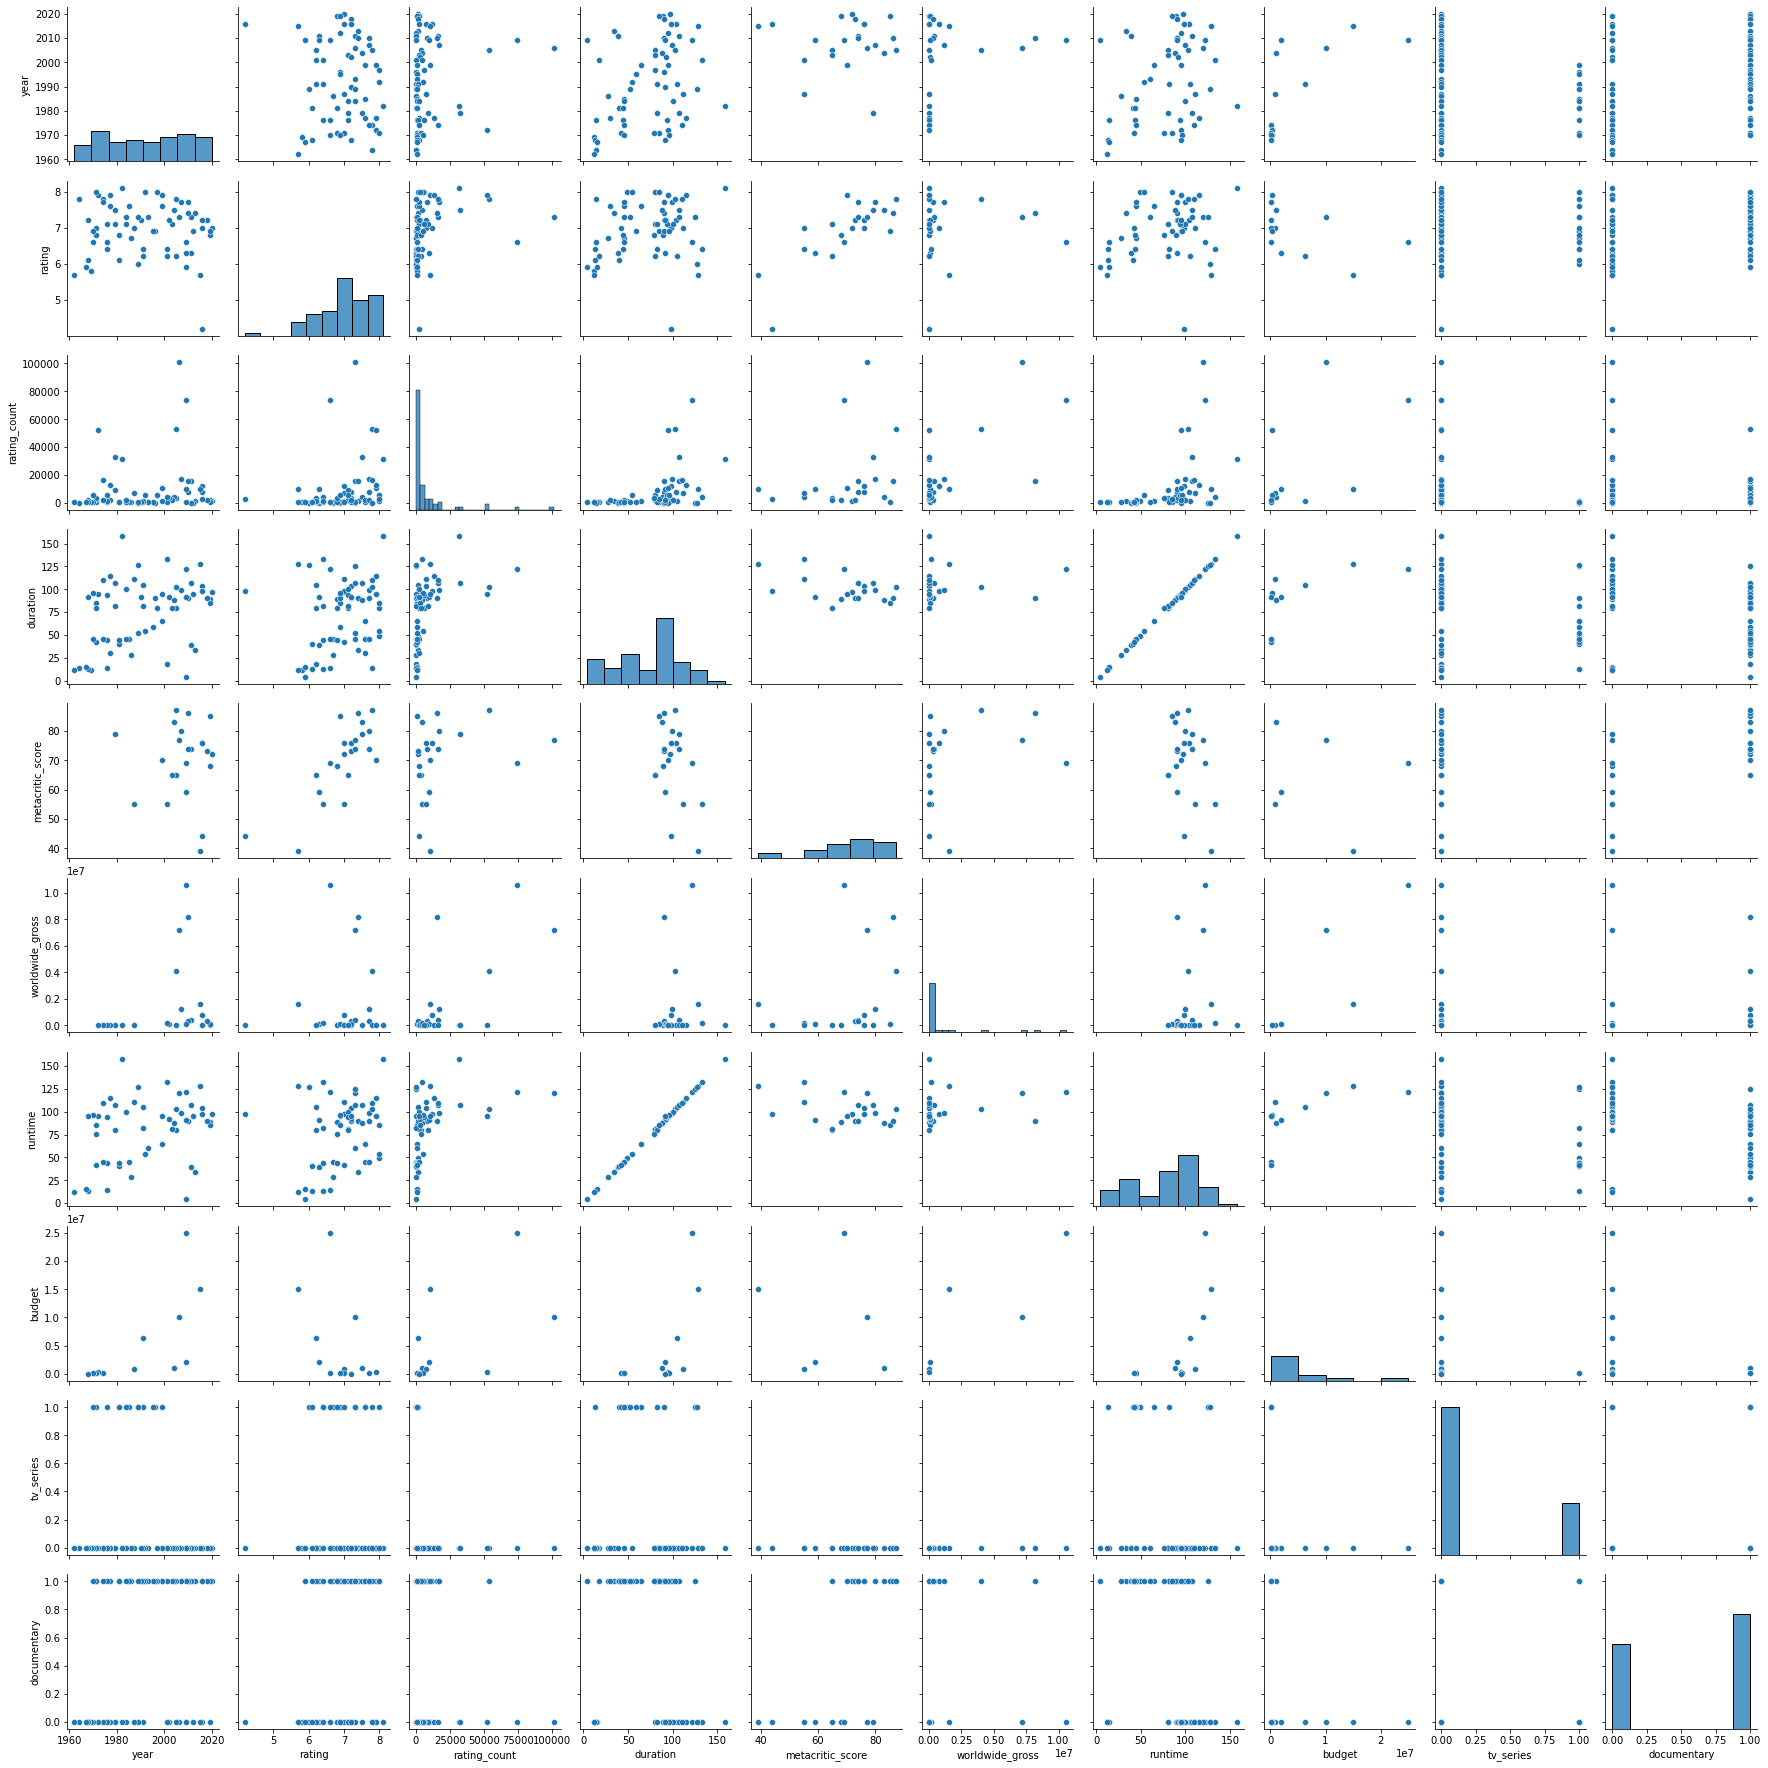

In [70]:
sns.pairplot( film_catalog )

In [ ]:
def traverse(soup):
    found = False
    if soup.name is not None:
        dom_dictionary = {}
        dom_dictionary['name'] = soup.name
        if dom_dictionary['name'] == 'h1':
            print('\n')
            print(soup.text)
            print('\n')
            if not found:
                found_object = soup
                found = True
        dom_dictionary['children'] = [ traverse(child) for child in soup.children if child.name is not None]
        return dom_dictionary, found_object

#traverse(soup)

### Test one film at a time

In [ ]:
#%%script false
# # Test area
# film_url='https://www.imdb.com/title/tt0086153/'
film_url = 'https://www.imdb.com/title/tt0084654/'

film_response = requests.get(film_url)
if(film_response.status_code < 400):
    film_page = film_response.text
    film_soup = BeautifulSoup(film_page, "lxml")
#   if ( not is_TV_Series( film_soup) ):
    film = parse_film_data( film_soup )
    print(film)
